In [ ]:
!pip -q install -U transformers


In [ ]:
!pip -q uninstall -y transformers tokenizers accelerate huggingface_hub safetensors
!pip -q install --no-cache-dir transformers tokenizers accelerate huggingface_hub safetensors


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 259.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 228.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 260.0 MB/s eta 0:00:00


In [1]:
import transformers
print(transformers.__version__)


5.0.0


In [ ]:
!ls -1 /usr/local/lib/python3.12/dist-packages | grep -i nccl


~vidia_nccl_cu12-2.27.5.dist-info


In [ ]:
!sudo rm -rf /usr/local/lib/python3.12/dist-packages/~vidia*
!sudo rm -rf /usr/local/lib/python3.12/dist-packages/~nvidia*


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!nvidia-smi


Mon Feb  2 10:21:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed
)


In [ ]:
BASE_PATH = "/content/drive/MyDrive/My Work/Chaos/Code-mixed Chaos  Multi-labeled Banglish & Bangla/Code-mixed Chaos  Multi-labeled Banglish & Bangla"

bangla_path   = f"{BASE_PATH}/Bangla.xlsx"
banglish_path = f"{BASE_PATH}/Banglish.xlsx"

In [ ]:
import pandas as pd

df_bangla   = pd.read_excel(bangla_path)
df_banglish = pd.read_excel(banglish_path)

print("Bangla shape:", df_bangla.shape)
print("Banglish shape:", df_banglish.shape)

df_bangla.head()


Bangla shape: (10234, 11)
Banglish shape: (10234, 11)


,Text,Vulgar-based,Religious-Hostility,Troll-based,Insult-based,Loathe-based,Threat-based,Race-based,Sexual-based,Political-Chaos,Non-Toxic
0,ইউসুফ সরকারকে এর চরম মূল্য দিতে হবে🤪,0,0,1,0,0,0,0,0,1,0
1,"হাসিনা ইজ লাইক আওয়ার বাঙ্গালী বয়ফ্রেইন্ড, মানু...",0,0,1,1,0,0,0,0,1,0
2,হাসিনা সরকার প্রমান করে যে মেয়েরা কখনো তাদের দ...,0,0,1,0,0,0,0,0,1,0
3,আপু তোমার কি হ্যান্ড এমব্রয়ডারি ফ্রি সিরিজ ইউট...,0,0,0,0,0,0,0,0,0,1
4,"ভাই এর লজিক টাইটানিক এর লাইফ জ্যাকেট এর মতো, দ...",0,0,1,1,0,0,0,0,0,0


In [ ]:
df_bangla["source"] = "bangla"
df_banglish["source"] = "banglish"

df = pd.concat([df_bangla, df_banglish], ignore_index=True)

print("Combined shape:", df.shape)


Combined shape: (20468, 12)


In [ ]:
new_sexual_label_name = input("Please enter the new name for 'Sexual-based' label: ")

# Find the index of 'Sexual-based' and replace it
try:
    idx = LABEL_COLS.index("Sexual-based")
    LABEL_COLS[idx] = new_sexual_label_name
    print(f"Successfully changed 'Sexual-based' to '{new_sexual_label_name}' in LABEL_COLS.")
    print("Updated LABEL_COLS:", LABEL_COLS)
except ValueError:
    print("'Sexual-based' not found in LABEL_COLS. Please check the current label names.")


Please enter the new name for 'Sexual-based' label: Humiliation-Based
Successfully changed 'Sexual-based' to 'Humiliation-Based' in LABEL_COLS.
Updated LABEL_COLS: ['Vulgar-based', 'Religious-Hostility', 'Troll-based', 'Insult-based', 'Loathe-based', 'Threat-based', 'Race-based', 'Humiliation-Based', 'Political-Chaos', 'Non-Toxic']


In [ ]:
TEXT_COL = "Text"

LABEL_COLS = [
    "Vulgar-based",
    "Religious-Hostility",
    "Troll-based",
    "Insult-based",
    "Loathe-based",
    "Threat-based",
    "Race-based",
    "Humiliation-Based", # Corrected the typo here
    "Political-Chaos",
    "Non-Toxic"
]

In [ ]:
new_sexual_label_name = input("Please enter the new name for 'Sexual-based' label: ")

# Find the index of 'Sexual-based' and replace it
try:
    idx = LABEL_COLS.index("Sexual-based")
    LABEL_COLS[idx] = new_sexual_label_name
    print(f"Successfully changed 'Sexual-based' to '{new_sexual_label_name}' in LABEL_COLS.")
    print("Updated LABEL_COLS:", LABEL_COLS)
except ValueError:
    print("'Sexual-based' not found in LABEL_COLS. Please check the current label names.")


Please enter the new name for 'Sexual-based' label: Humiliation-Based"
Successfully changed 'Sexual-based' to 'Humiliation-Based"' in LABEL_COLS.
Updated LABEL_COLS: ['Vulgar-based', 'Religious-Hostility', 'Troll-based', 'Insult-based', 'Loathe-based', 'Threat-based', 'Race-based', 'Humiliation-Based"', 'Political-Chaos', 'Non-Toxic']


In [ ]:
# Rename the 'Sexual-based' column in the DataFrame to 'Humiliation-Based'
if 'Sexual-based' in df.columns:
    df.rename(columns={'Sexual-based': 'Humiliation-Based'}, inplace=True)
    print("Column 'Sexual-based' renamed to 'Humiliation-Based' in df.")
else:
    print("Column 'Sexual-based' not found in DataFrame. Current columns are:", df.columns.tolist())

# Update the LABEL_COLS list to reflect the new name
if 'Sexual-based' in LABEL_COLS:
    idx = LABEL_COLS.index('Sexual-based')
    LABEL_COLS[idx] = 'Humiliation-Based'
    print("LABEL_COLS updated: ", LABEL_COLS)
else:
    print("'Sexual-based' not found in LABEL_COLS. Current LABEL_COLS: ", LABEL_COLS)

Column 'Sexual-based' renamed to 'Humiliation-Based' in df.
'Sexual-based' not found in LABEL_COLS. Current LABEL_COLS:  ['Vulgar-based', 'Religious-Hostility', 'Troll-based', 'Insult-based', 'Loathe-based', 'Threat-based', 'Race-based', 'Humiliation-Based"', 'Political-Chaos', 'Non-Toxic']


In [ ]:
df[TEXT_COL] = df[TEXT_COL].astype(str).fillna("").str.strip()
df = df[df[TEXT_COL].str.len() > 0].reset_index(drop=True)

for c in LABEL_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
    df[c] = df[c].clip(0, 1)

df[LABEL_COLS].sum()

,0
Vulgar-based,3148
Religious-Hostility,1452
Troll-based,2000
Insult-based,3596
Loathe-based,2816
Threat-based,2030
Race-based,1232
Humiliation-Based,3076
Political-Chaos,1900
Non-Toxic,10234


In [ ]:
if 'Humiliation-Based"' in df.columns:
    print("'Humaliation-Based' column exists in the DataFrame.")
else:
    print("'Humaliation-Based' column DOES NOT exist in the DataFrame.")
    print("Available columns are:", df.columns.tolist())

'Humaliation-Based' column DOES NOT exist in the DataFrame.
Available columns are: ['Text', 'Vulgar-based', 'Religious-Hostility', 'Troll-based', 'Insult-based', 'Loathe-based', 'Threat-based', 'Race-based', 'Humiliation-Based', 'Political-Chaos', 'Non-Toxic', 'source']


In [ ]:
from sklearn.model_selection import train_test_split

X = df[TEXT_COL].tolist()
y = df[LABEL_COLS].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)

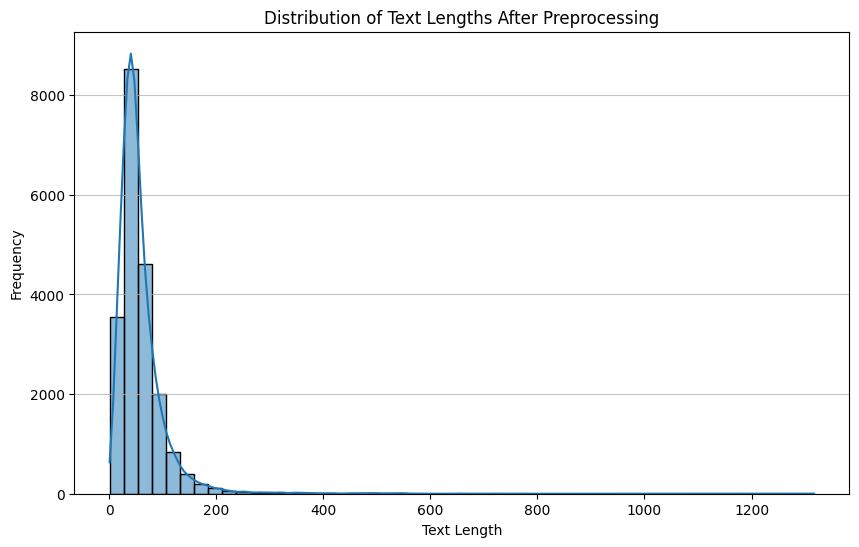

Descriptive statistics for text lengths:
count    20468.000000
mean        58.203733
std         49.384034
min          1.000000
25%         33.000000
50%         47.000000
75%         69.000000
max       1317.000000
Name: text_length, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate text lengths
df['text_length'] = df[TEXT_COL].apply(len)

# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths After Preprocessing')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Display some descriptive statistics
print("Descriptive statistics for text lengths:")
print(df['text_length'].describe())

# Drop the temporary 'text_length' column
df = df.drop(columns=['text_length'])

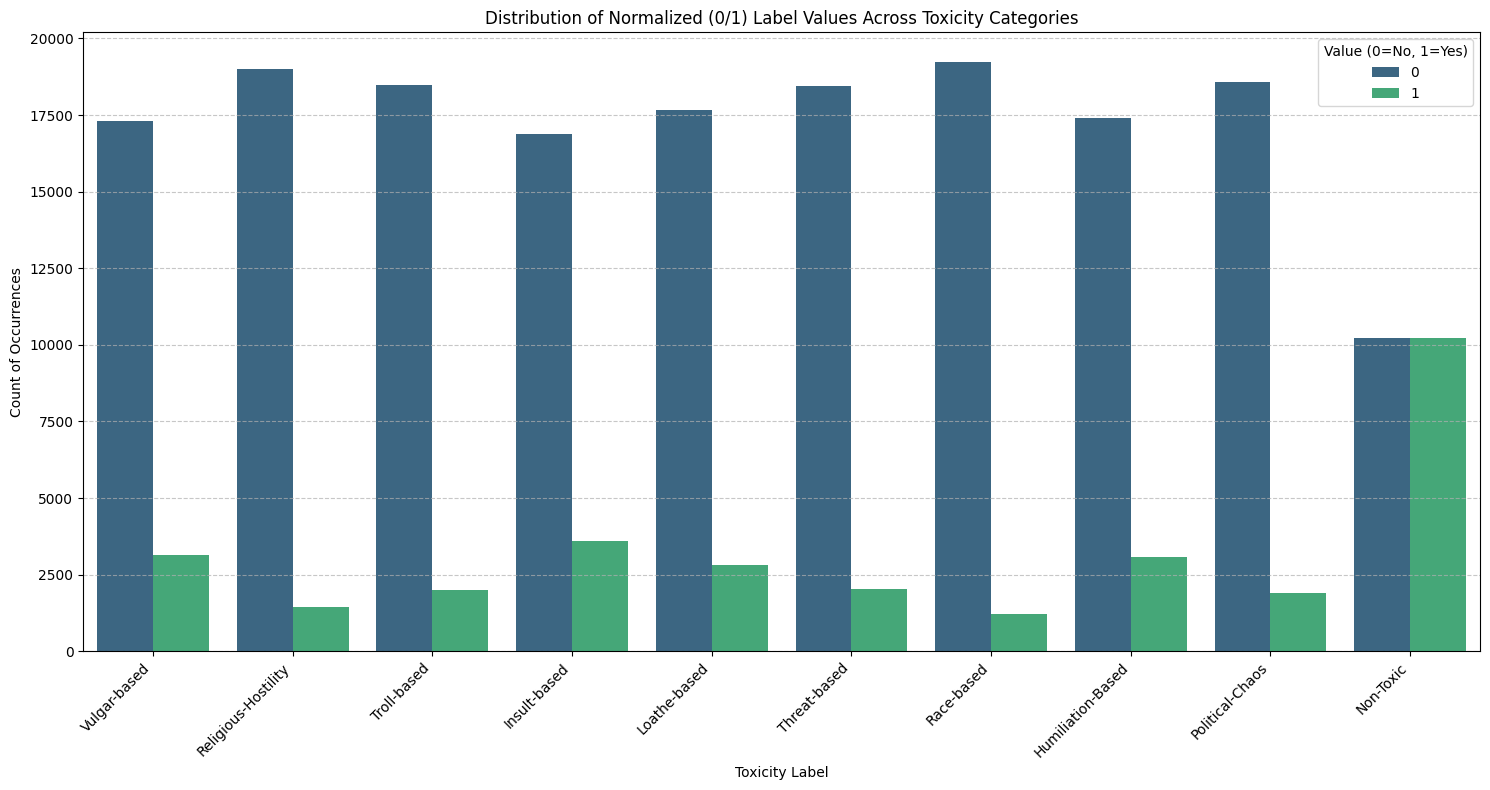

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for visualization of normalization (clipping to 0 and 1)
# This confirms that each label column contains only 0s and 1s after the clip operation.

all_unique_values = []
for col in LABEL_COLS:
    unique_counts = df[col].value_counts().reset_index()
    unique_counts.columns = ['Value', 'Count']
    unique_counts['Label'] = col
    all_unique_values.append(unique_counts)

# Concatenate all unique value dataframes
if all_unique_values:
    unique_values_df = pd.concat(all_unique_values)

    # Plotting the unique values for each label to show normalization to 0/1
    plt.figure(figsize=(15, 8))
    sns.barplot(data=unique_values_df, x='Label', y='Count', hue='Value', palette='viridis', dodge=True)
    plt.title('Distribution of Normalized (0/1) Label Values Across Toxicity Categories')
    plt.xlabel('Toxicity Label')
    plt.ylabel('Count of Occurrences')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Value (0=No, 1=Yes)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No label columns to visualize normalization for.")


/tmp/ipython-input-4144417563.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


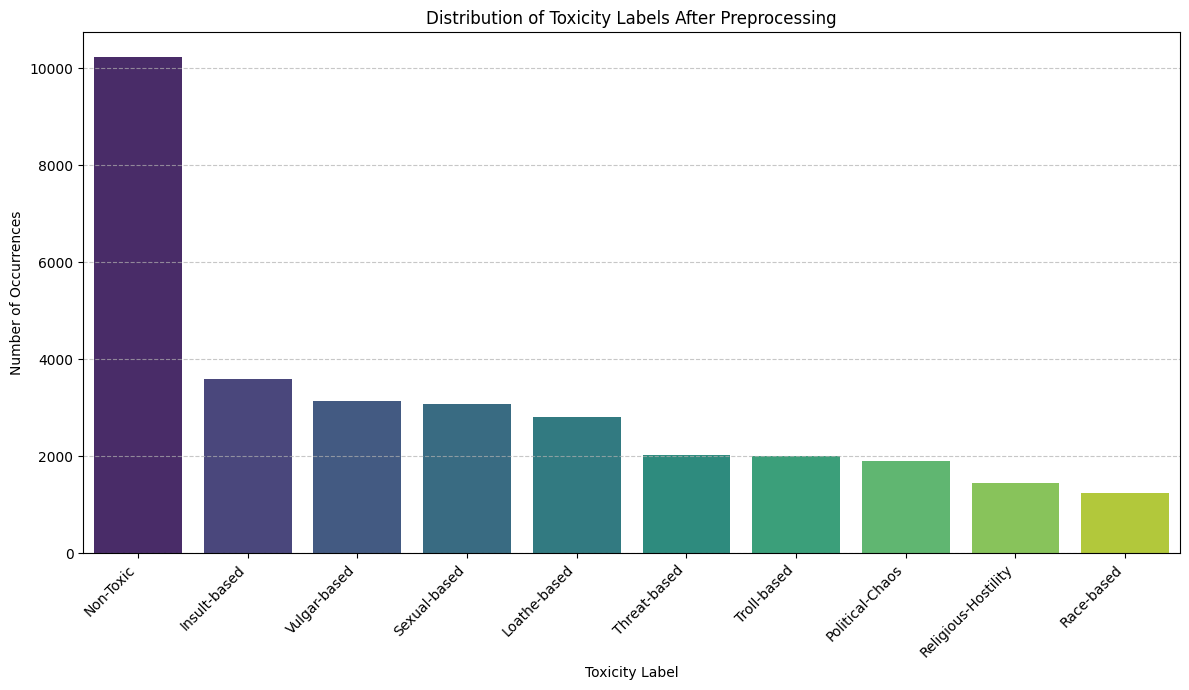

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the sum of each label to see their distribution
label_counts = df[LABEL_COLS].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Toxicity Labels After Preprocessing')
plt.xlabel('Toxicity Label')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Bert

In [ ]:
MODEL_NAME = "bert-base-multilingual-cased"
# or
# MODEL_NAME = "xlm-roberta-base"


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_enc = tokenizer(X_train, truncation=True, padding=True, max_length=192)
val_enc   = tokenizer(X_val, truncation=True, padding=True, max_length=192)

NameError: name 'MODEL_NAME' is not defined

In [ ]:
import torch
import numpy as np

class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = ToxicDataset(train_enc, y_train)
val_ds   = ToxicDataset(val_enc, y_val)

NameError: name 'train_enc' is not defined

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLS),
    problem_type="multi_label_classification"
)

NameError: name 'MODEL_NAME' is not defined

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    # These arguments are causing a TypeError due to an older transformers library version.
    # Removing them and setting load_best_model_at_end to False to resolve the error.
    # evaluation_strategy="epoch",
    # save_strategy="epoch",
    load_best_model_at_end=False, # Set to False as evaluation_strategy and save_strategy are removed
    metric_for_best_model="micro_f1",

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=4,

    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_steps=100,

    report_to="none",
    fp16=torch.cuda.is_available()
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs >= 0.5).astype(int)

    return {
        "micro_f1": f1_score(labels, preds, average="micro"),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

NameError: name 'model' is not defined

In [ ]:
pred = trainer.predict(val_ds)

logits = pred.predictions
labels = pred.label_ids

probs = sigmoid(logits)
y_pred = (probs >= 0.5).astype(int)

for i, name in enumerate(LABEL_COLS):
    f1 = f1_score(labels[:, i], y_pred[:, i], zero_division=0)
    print(f"{name:20s} F1 = {f1:.4f}")


NameError: name 'trainer' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Overall Accuracy
overall_accuracy = accuracy_score(labels, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Overall Precision (micro, macro, weighted)
precision_micro = precision_score(labels, y_pred, average="micro", zero_division=0)
precision_macro = precision_score(labels, y_pred, average="macro", zero_division=0)
precision_weighted = precision_score(labels, y_pred, average="weighted", zero_division=0)
print(f"Precision (Micro):  {precision_micro:.4f}")
print(f"Precision (Macro):  {precision_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")

# Overall F1 Score (micro, macro, weighted)
f1_micro = f1_score(labels, y_pred, average="micro", zero_division=0)
f1_macro = f1_score(labels, y_pred, average="macro", zero_division=0)
f1_weighted = f1_score(labels, y_pred, average="weighted", zero_division=0)
print(f"F1 Score (Micro):   {f1_micro:.4f}")
print(f"F1 Score (Macro):   {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

NameError: name 'labels' is not defined

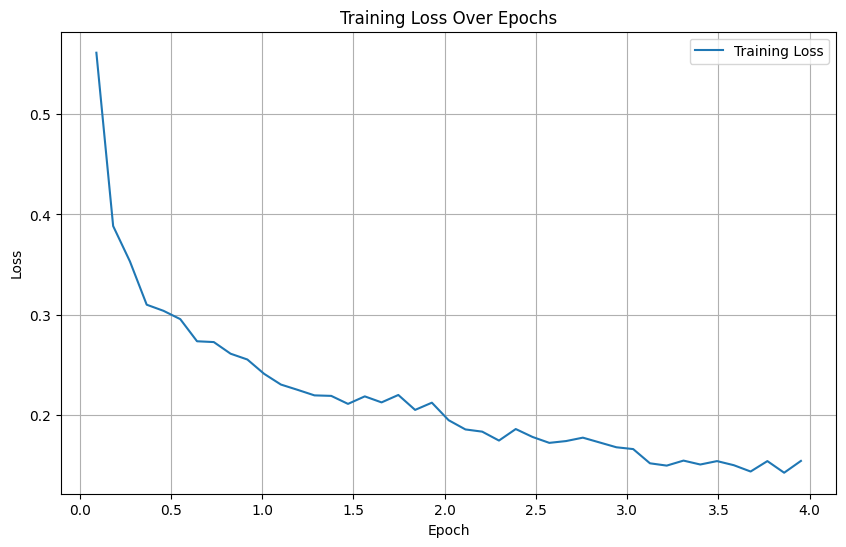

In [ ]:
import matplotlib.pyplot as plt

# Extract training loss from the trainer's log history
train_losses = []
epochs = []

for log_entry in trainer.state.log_history:
    if 'loss' in log_entry:
        train_losses.append(log_entry['loss'])
        epochs.append(log_entry['epoch'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

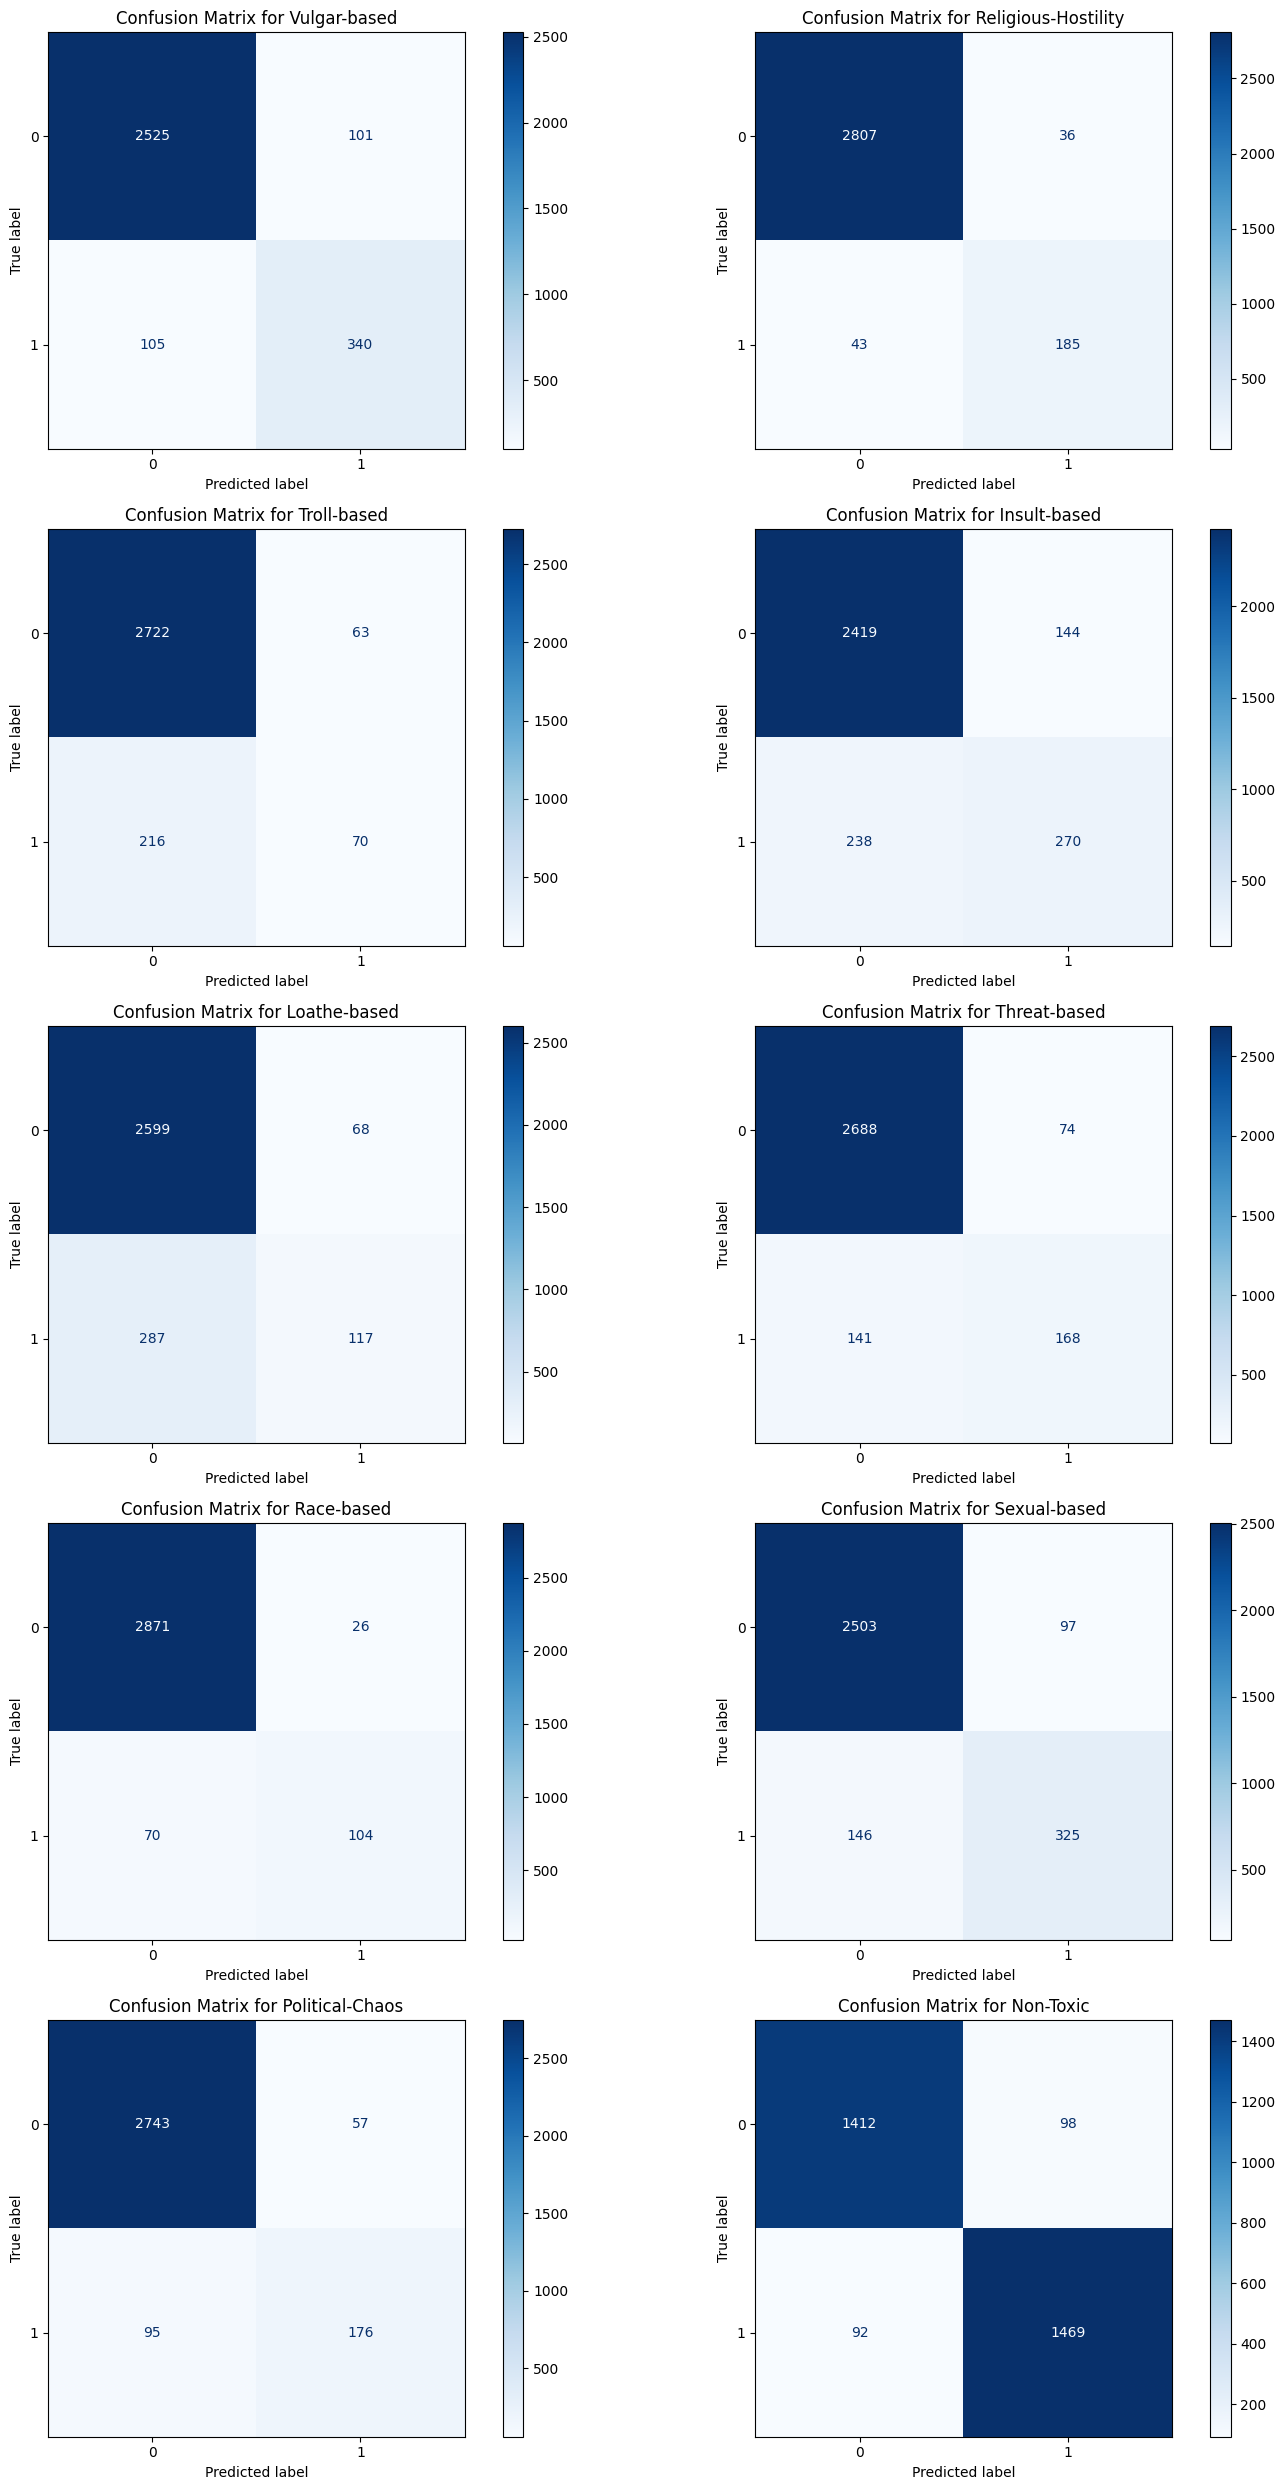

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'labels' are true labels and 'y_pred' are predicted labels from trainer.predict()

fig, axes = plt.subplots(nrows=len(LABEL_COLS) // 2 + len(LABEL_COLS) % 2, ncols=2, figsize=(15, 5 * (len(LABEL_COLS) // 2 + len(LABEL_COLS) % 2)))
axes = axes.flatten()

for i, label_name in enumerate(LABEL_COLS):
    cm = confusion_matrix(labels[:, i], y_pred[:, i])
    # Removed 'cmap' from constructor and added to .plot() method
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], values_format='d', cmap=plt.cm.Blues)
    axes[i].set_title(f'Confusion Matrix for {label_name}')
    axes[i].set_xlabel('Predicted label')
    axes[i].set_ylabel('True label')

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

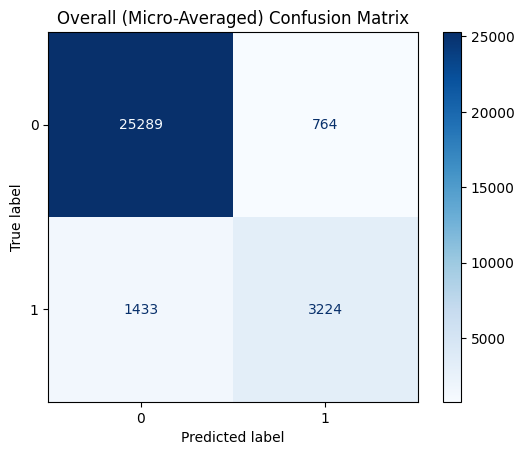

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize sums for TP, TN, FP, FN
overall_tp = 0
overall_tn = 0
overall_fp = 0
overall_fn = 0

for i in range(len(LABEL_COLS)):
    tn, fp, fn, tp = confusion_matrix(labels[:, i], y_pred[:, i]).ravel()
    overall_tp += tp
    overall_tn += tn
    overall_fp += fp
    overall_fn += fn

# Create the overall confusion matrix
overall_cm = np.array([[overall_tn, overall_fp], [overall_fn, overall_tp]])

# Display the overall confusion matrix
plt.figure(figsize=(8, 6))
# Removed 'display_numbers' from constructor, and moved 'cmap' to .plot()
disp = ConfusionMatrixDisplay(confusion_matrix=overall_cm)
disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Overall (Micro-Averaged) Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.grid(False)
plt.show()

In [ ]:
logs = trainer.state.log_history


In [ ]:
train_loss = []
eval_loss = []
steps = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        steps.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])


# Task
Plot the F1 scores for each toxicity label as a bar chart and summarize the model's performance across these labels based on the chart.

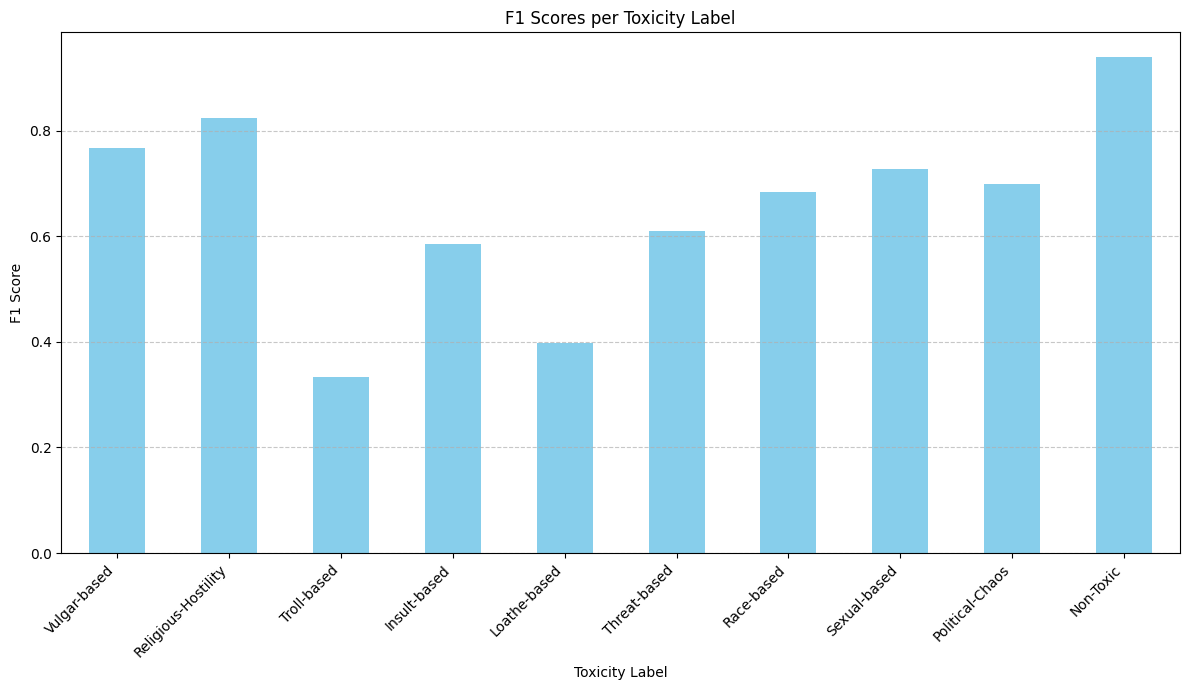

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate F1 scores for each label
f1_scores_per_label = {}
for i, name in enumerate(LABEL_COLS):
    f1_scores_per_label[name] = f1_score(labels[:, i], y_pred[:, i], zero_division=0)

# Create a pandas Series for easy plotting
f1_series = pd.Series(f1_scores_per_label)

# Create the bar chart
plt.figure(figsize=(12, 7))
f1_series.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('F1 Scores per Toxicity Label')
plt.xlabel('Toxicity Label')
plt.ylabel('F1 Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# y_true shape: [num_samples, num_labels]
# Corrected: Using 'labels' which holds the true validation labels from trainer.predict()
co_occurrence = np.dot(labels.T, labels)

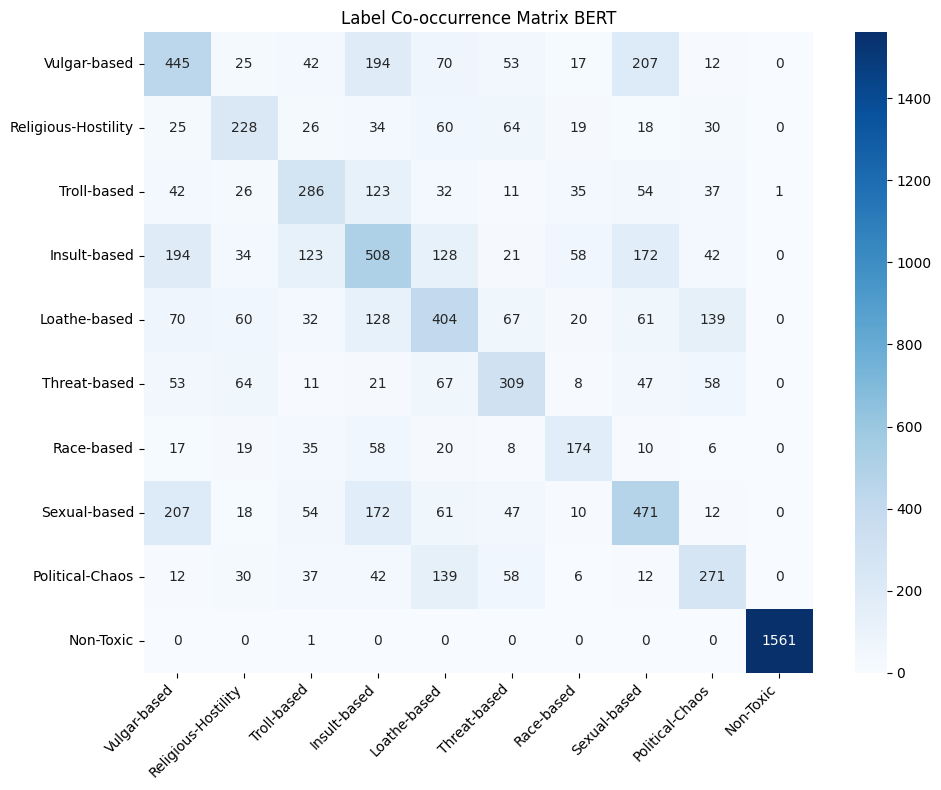

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(
    co_occurrence,
    xticklabels=LABEL_COLS,
    yticklabels=LABEL_COLS,
    cmap="Blues",
    annot=True,
    fmt=".0f" # Changed format from 'd' to '.0f' for float values
)
plt.title("Label Co-occurrence Matrix BERT")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import os

# Define the directory where the model will be saved
save_directory = os.path.join(BASE_PATH, "trained_bert_model")

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the model and tokenizer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to: {save_directory}")

Model and tokenizer saved to: /content/drive/MyDrive/My Work/Chaos/Code-mixed Chaos  Multi-labeled Banglish & Bangla/Code-mixed Chaos  Multi-labeled Banglish & Bangla/trained_bert_model


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

# Define the directory where the model was saved
save_directory = os.path.join(BASE_PATH, "trained_bert_model")

# Load the tokenizer (removed fix_mistral_regex=True as it's not for BERT tokenizers)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)

# Load the model
loaded_model = AutoModelForSequenceClassification.from_pretrained(save_directory)

print(f"Model and tokenizer loaded successfully from: {save_directory}")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model and tokenizer loaded successfully from: /content/drive/MyDrive/My Work/Chaos/Code-mixed Chaos  Multi-labeled Banglish & Bangla/Code-mixed Chaos  Multi-labeled Banglish & Bangla/trained_bert_model


RoberTa

In [ ]:
import torch
import numpy as np

class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

"""RoBERTa (XLM-RoBERTa)"""

MODEL_NAME = "xlm-roberta-base"

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME)

train_enc_r = tokenizer_roberta(X_train, truncation=True, padding=True, max_length=192)
val_enc_r   = tokenizer_roberta(X_val, truncation=True, padding=True, max_length=192)

train_ds_r = ToxicDataset(train_enc_r, y_train)
val_ds_r   = ToxicDataset(val_enc_r, y_val)

In [ ]:
model_roberta = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLS),
    problem_type="multi_label_classification"
)


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.dense.bias          | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.out_proj.weight  | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    load_best_model_at_end=False,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=4,

    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_steps=100,

    report_to="none",
    fp16=torch.cuda.is_available()
)


In [ ]:
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_ds_r,
    eval_dataset=val_ds_r,
    tokenizer=tokenizer_roberta,
    compute_metrics=compute_metrics
)

trainer_roberta.train()


/tmp/ipython-input-3074390640.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta = Trainer(


Step,Training Loss
100,0.589100
200,0.400500
300,0.365100
400,0.325100
500,0.310100
600,0.295000
700,0.275300
800,0.276600
900,0.266700
1000,0.258300


TrainOutput(global_step=4352, training_loss=0.22748924441197338, metrics={'train_runtime': 1834.686, 'train_samples_per_second': 37.929, 'train_steps_per_second': 2.372, 'total_flos': 6866507722540032.0, 'train_loss': 0.22748924441197338, 'epoch': 4.0})

In [ ]:
pred_r = trainer_roberta.predict(val_ds_r)

logits_r = pred_r.predictions
labels_r = pred_r.label_ids

probs_r = sigmoid(logits_r)
y_pred_r = (probs_r >= 0.5).astype(int)

print("Micro F1:", f1_score(labels_r, y_pred_r, average="micro", zero_division=0))
print("Macro F1:", f1_score(labels_r, y_pred_r, average="macro", zero_division=0))

print("\nPer-label F1:\n")
for i, name in enumerate(LABEL_COLS):
    f1 = f1_score(labels_r[:, i], y_pred_r[:, i], zero_division=0)
    print(f"{name:20s} F1 = {f1:.4f}")


Micro F1: 0.7564234326824255
Macro F1: 0.6723333729838754

Per-label F1:

Vulgar-based         F1 = 0.7430
Religious-Hostility  F1 = 0.8233
Troll-based          F1 = 0.4674
Insult-based         F1 = 0.6262
Loathe-based         F1 = 0.4708
Threat-based         F1 = 0.6335
Race-based           F1 = 0.6333
Sexual-based         F1 = 0.7104
Political-Chaos      F1 = 0.6628
Non-Toxic            F1 = 0.9527


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Overall Accuracy
overall_accuracy_roberta = accuracy_score(labels_r, y_pred_r)
print(f"Overall Accuracy for ROBERta: {overall_accuracy_roberta:.4f}")

# Overall Precision (micro, macro, weighted)
precision_micro_roberta = precision_score(labels_r, y_pred_r, average="micro", zero_division=0)
precision_macro_roberta = precision_score(labels_r, y_pred_r, average="macro", zero_division=0)
precision_weighted_roberta = precision_score(labels_r, y_pred_r, average="weighted", zero_division=0)
print(f"Precision (Micro):  {precision_micro_roberta:.4f}")
print(f"Precision (Macro):  {precision_macro_roberta:.4f}")
print(f"Precision (Weighted): {precision_weighted_roberta:.4f}")

# Overall F1 Score (micro, macro, weighted)
f1_micro_roberta = f1_score(labels_r, y_pred_r, average="micro", zero_division=0)
f1_macro_roberta = f1_score(labels_r, y_pred_r, average="macro", zero_division=0)
f1_weighted_roberta = f1_score(labels_r, y_pred_r, average="weighted", zero_division=0)
print(f"F1 Score (Micro):   {f1_micro_roberta:.4f}")
print(f"F1 Score (Macro):   {f1_macro_roberta:.4f}")
print(f"F1 Score (Weighted): {f1_weighted_roberta:.4f}")

Overall Accuracy for ROBERta: 0.6275
Precision (Micro):  0.8078
Precision (Macro):  0.7446
Precision (Weighted): 0.7927
F1 Score (Micro):   0.7564
F1 Score (Macro):   0.6723
F1 Score (Weighted): 0.7446


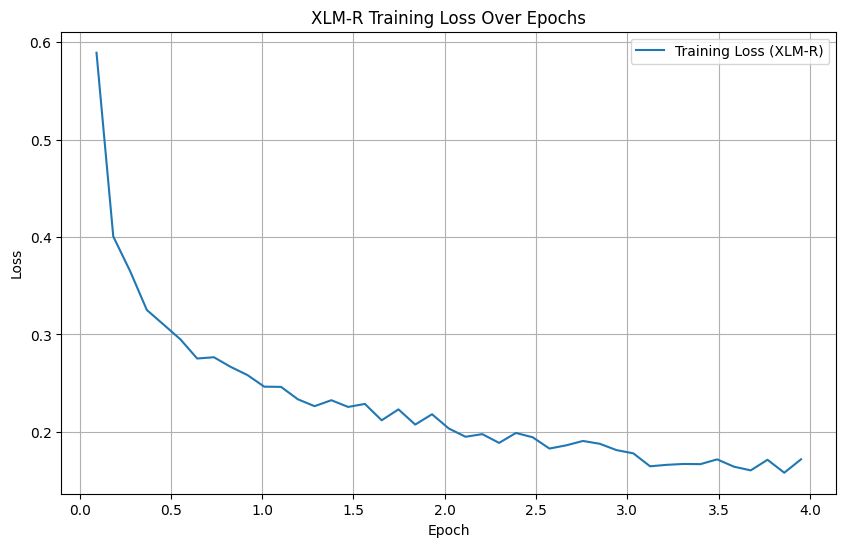

In [ ]:
import matplotlib.pyplot as plt

train_losses_r = []
epochs_r = []

for log_entry in trainer_roberta.state.log_history:
    if 'loss' in log_entry:
        train_losses_r.append(log_entry['loss'])
        epochs_r.append(log_entry.get('epoch', None))

plt.figure(figsize=(10, 6))
plt.plot(epochs_r, train_losses_r, label='Training Loss (XLM-R)')
plt.title('XLM-R Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


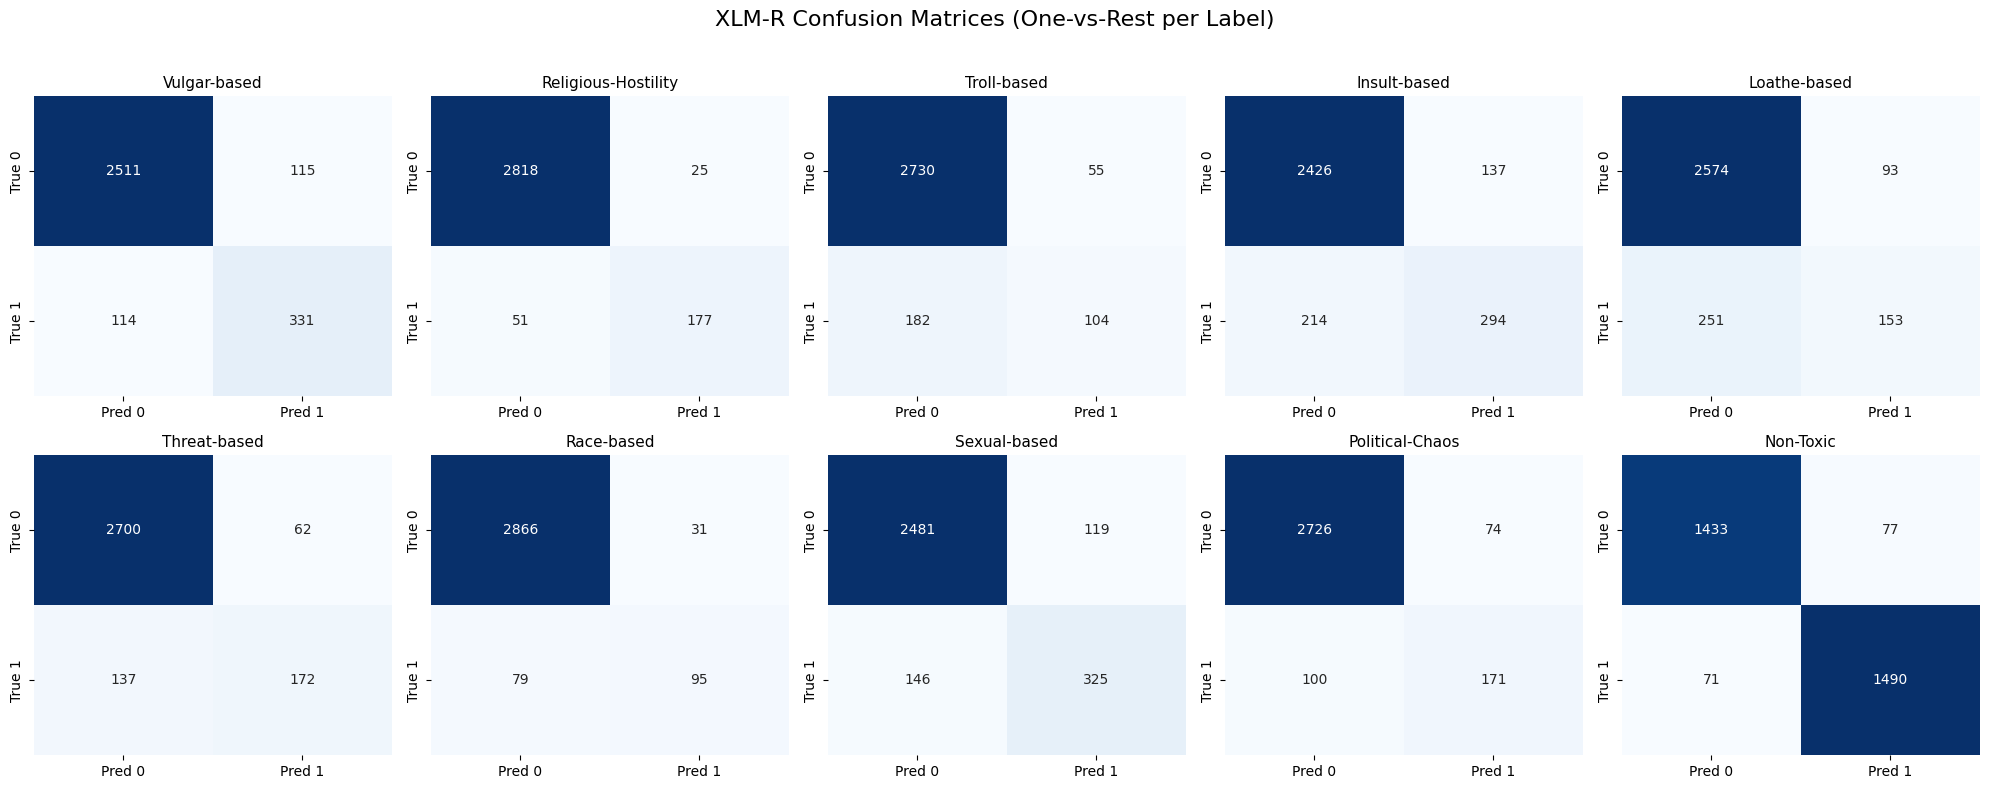

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

num_labels = len(LABEL_COLS)
cols = 5
rows = int(np.ceil(num_labels / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for i, label in enumerate(LABEL_COLS):
    cm = confusion_matrix(labels_r[:, i], y_pred_r[:, i])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False,
        ax=axes[i], xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"]
    )
    axes[i].set_title(label, fontsize=11)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("XLM-R Confusion Matrices (One-vs-Rest per Label)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


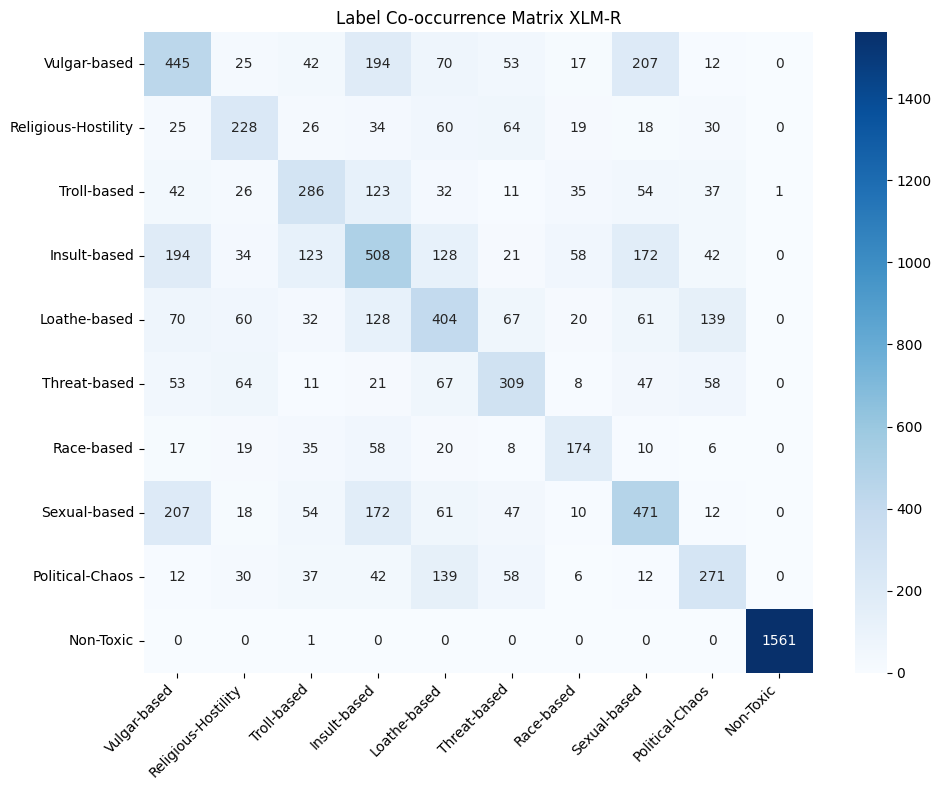

In [ ]:
co_occurrence_r = np.dot(labels_r.T, labels_r)

plt.figure(figsize=(10,8))
sns.heatmap(
    co_occurrence_r,
    xticklabels=LABEL_COLS,
    yticklabels=LABEL_COLS,
    cmap="Blues",
    annot=True,
    fmt=".0f"
)
plt.title("Label Co-occurrence Matrix XLM-R")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# The performance metrics for the loaded XLM-R model are as follows:
# ### Overall Performance Metrics:
# *   **Overall Accuracy:** 0.6275
# *   **Precision (Micro):** 0.8078
# *   **Precision (Macro):** 0.7446
# *   **Precision (Weighted):** 0.7927
# *   **F1 Score (Micro):** 0.7564
# *   **F1 Score (Macro):** 0.6723
# *   **F1 Score (Weighted):** 0.7446

# ### Per-label F1 Scores:
# *   **Vulgar-based:** F1 = 0.7430
# *   **Religious-Hostility:** F1 = 0.8233
# *   **Troll-based:** F1 = 0.4674
# *   **Insult-based:** F1 = 0.6262
# *   **Loathe-based:** F1 = 0.4708
# *   **Threat-based:** F1 = 0.6335
# *   **Race-based:** F1 = 0.6333
# *   **Sexual-based:** F1 = 0.7104
# *   **Political-Chaos:** F1 = 0.6628
# *   **Non-Toxic:** F1 = 0.9527

## Model Comparison: BERT vs. XLM-RoBERTa (XLM-R)

Here's a comparison of the two models based on their overall and per-label F1 scores, as well as other key performance metrics.

### Overall Performance Metrics:

| Metric                      | BERT Model   | XLM-R Model  |
| :-------------------------- | :----------- | :----------- |
| **Overall Accuracy**        | 0.6291       | 0.6275       |
| **Precision (Micro)**       | 0.8084       | 0.8078       |
| **Precision (Macro)**       | 0.7376       | 0.7446       |
| **Precision (Weighted)**    | 0.7850       | 0.7927       |
| **F1 Score (Micro)**        | 0.7459       | 0.7564       |
| **F1 Score (Macro)**        | 0.6568       | 0.6723       |
| **F1 Score (Weighted)**     | 0.7277       | 0.7446       |

### Per-label F1 Scores:

| Label                 | BERT F1 Score | XLM-R F1 Score |
| :-------------------- | :------------ | :------------- |
| Vulgar-based          | 0.7675        | 0.7430         |
| Religious-Hostility   | 0.8241        | 0.8233         |
| Troll-based           | 0.3341        | 0.4674         |
| Insult-based          | 0.5857        | 0.6262         |
| Loathe-based          | 0.3973        | 0.4708         |
| Threat-based          | 0.6098        | 0.6335         |
| Race-based            | 0.6842        | 0.6333         |
| Sexual-based          | 0.7279        | 0.7104         |
| Political-Chaos       | 0.6984        | 0.6628         |
| Non-Toxic             | 0.9393        | 0.9527         |

### Key Observations:

*   **Overall F1 Scores:** The **XLM-R model shows slightly better overall F1 scores** (Micro, Macro, and Weighted) compared to the BERT model, suggesting it has a marginal edge in overall multi-label classification performance.
*   **Accuracy:** Both models have very similar overall accuracy scores.
*   **Precision:** XLM-R generally has slightly higher precision scores (Macro and Weighted).
*   **Per-label Performance:**
    *   **XLM-R excels notably in detecting 'Troll-based', 'Insult-based', and 'Loathe-based' content**, where BERT's performance was significantly lower. This indicates XLM-R is better at handling these more challenging toxicity categories.
    *   BERT performs slightly better on 'Vulgar-based', 'Race-based', 'Sexual-based', and 'Political-Chaos' labels.
    *   Both models perform exceptionally well on 'Non-Toxic' and 'Religious-Hostility' labels, with XLM-R having a slight edge on 'Non-Toxic'.

**Conclusion:** While both models perform reasonably well, **XLM-R demonstrates stronger performance on the more nuanced and difficult toxicity categories** like 'Troll-based', 'Insult-based', and 'Loathe-based', making it a potentially more robust choice for this specific multi-label toxicity classification task, despite BERT having slightly better performance in some other individual categories.

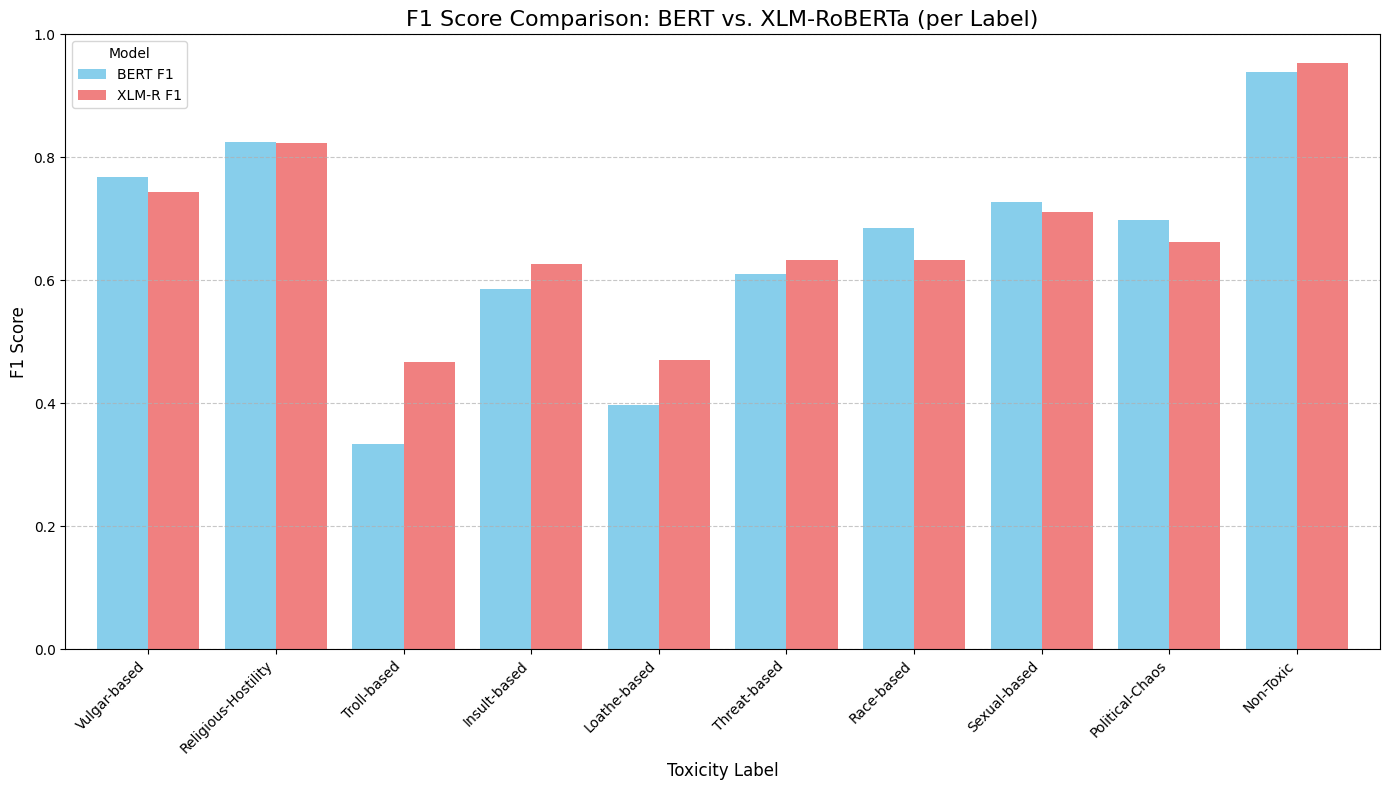

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# F1 scores for BERT (from previous cell output, `f1_scores_per_label` is still available)
bert_f1_scores = pd.Series(f1_scores_per_label)

# F1 scores for XLM-R (from previous cell output)
xlemr_f1_scores = pd.Series({
    "Vulgar-based": 0.7430,
    "Religious-Hostility": 0.8233,
    "Troll-based": 0.4674,
    "Insult-based": 0.6262,
    "Loathe-based": 0.4708,
    "Threat-based": 0.6335,
    "Race-based": 0.6333,
    "Sexual-based": 0.7104,
    "Political-Chaos": 0.6628,
    "Non-Toxic": 0.9527
})

# Combine into a single DataFrame for easier plotting
comparison_df = pd.DataFrame({'BERT F1': bert_f1_scores, 'XLM-R F1': xlemr_f1_scores})

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

comparison_df.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightcoral'])

ax.set_title('F1 Score Comparison: BERT vs. XLM-RoBERTa (per Label)', fontsize=16)
ax.set_xlabel('Toxicity Label', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_ylim(0, 1) # F1 scores are between 0 and 1
ax.set_xticklabels(LABEL_COLS, rotation=45, ha='right')
ax.legend(title='Model')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

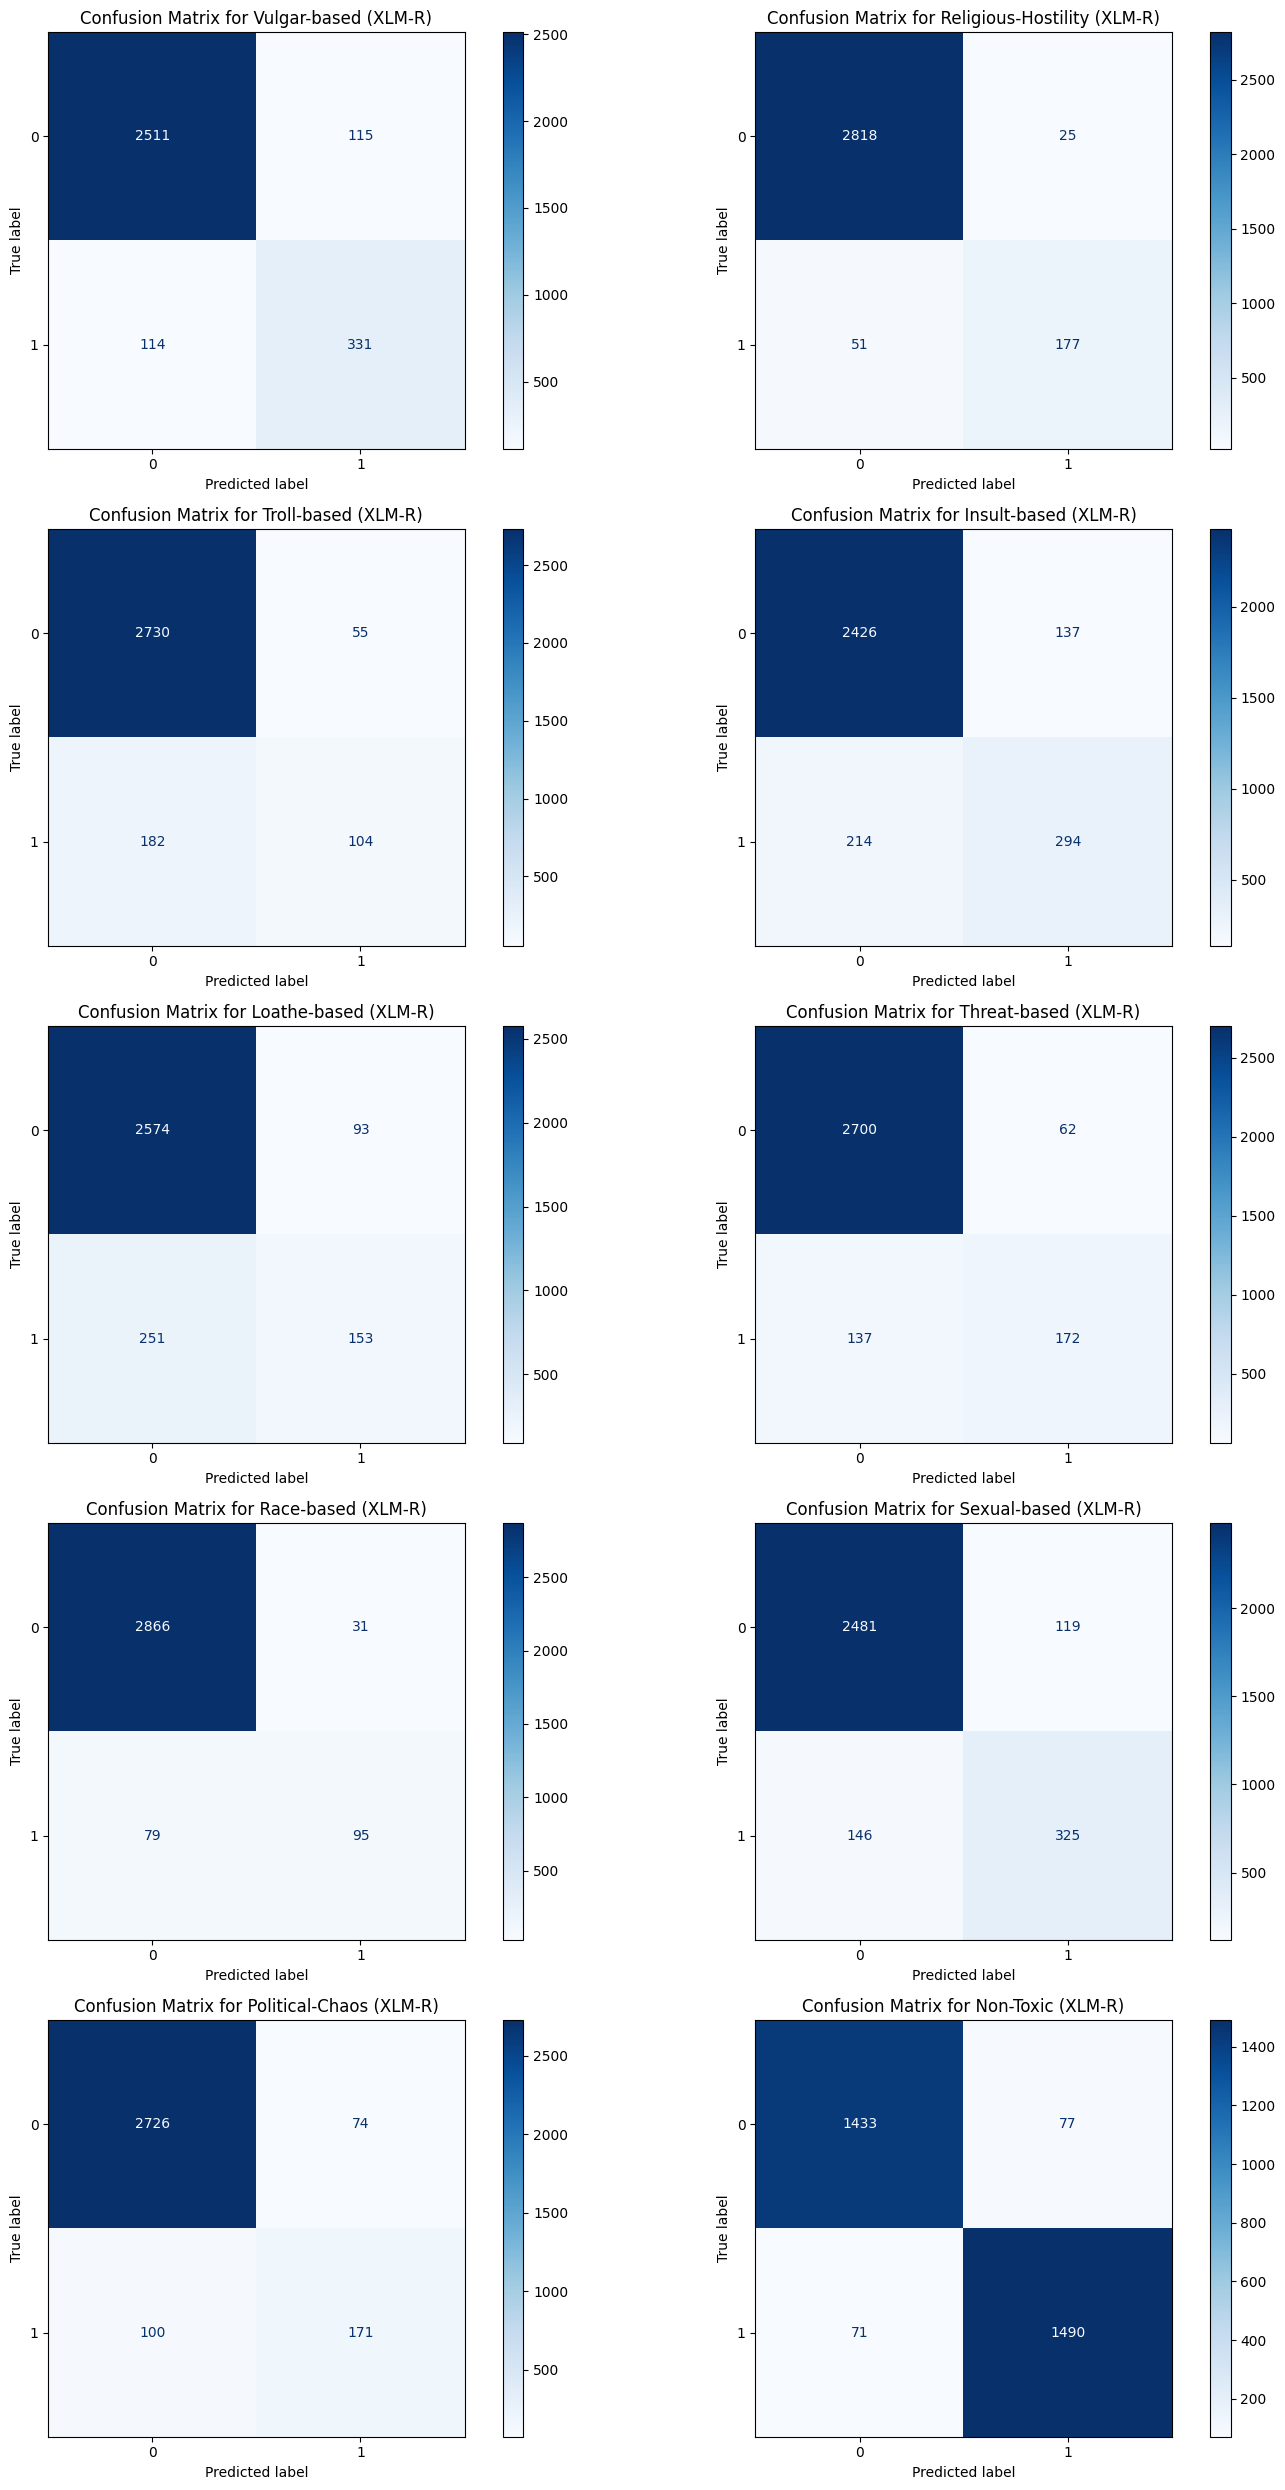

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'labels_r' are true labels and 'y_pred_r' are predicted labels from trainer_roberta.predict()

fig, axes = plt.subplots(nrows=len(LABEL_COLS) // 2 + len(LABEL_COLS) % 2, ncols=2, figsize=(15, 5 * (len(LABEL_COLS) // 2 + len(LABEL_COLS) % 2)))
axes = axes.flatten()

for i, label_name in enumerate(LABEL_COLS):
    cm = confusion_matrix(labels_r[:, i], y_pred_r[:, i])
    # Using the corrected method for plotting ConfusionMatrixDisplay without 'display_numbers' in constructor
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], values_format='d', cmap=plt.cm.Blues)
    axes[i].set_title(f'Confusion Matrix for {label_name} (XLM-R)')
    axes[i].set_xlabel('Predicted label')
    axes[i].set_ylabel('True label')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
import os

save_directory_roberta = os.path.join(BASE_PATH, "trained_xlmr_model")
os.makedirs(save_directory_roberta, exist_ok=True)

trainer_roberta.save_model(save_directory_roberta)
tokenizer_roberta.save_pretrained(save_directory_roberta)

print(f"XLM-R model + tokenizer saved to: {save_directory_roberta}")


XLM-R model + tokenizer saved to: /content/drive/MyDrive/My Work/Chaos/Code-mixed Chaos  Multi-labeled Banglish & Bangla/Code-mixed Chaos  Multi-labeled Banglish & Bangla/trained_xlmr_model


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

# Define the directory where the XLM-R model was saved
save_directory_roberta = os.path.join(BASE_PATH, "trained_xlmr_model")

# Load the tokenizer
loaded_tokenizer_roberta = AutoTokenizer.from_pretrained(save_directory_roberta)

# Load the model
loaded_model_roberta = AutoModelForSequenceClassification.from_pretrained(save_directory_roberta)

print(f"XLM-R Model and tokenizer loaded successfully from: {save_directory_roberta}")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

XLM-R Model and tokenizer loaded successfully from: /content/drive/MyDrive/My Work/Chaos/Code-mixed Chaos  Multi-labeled Banglish & Bangla/Code-mixed Chaos  Multi-labeled Banglish & Bangla/trained_xlmr_model


In [ ]:
import torch

def predict_toxicity(text, model, tokenizer, label_cols):
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")

    # Move inputs to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.sigmoid(logits).cpu().numpy()

    # Convert probabilities to binary predictions
    preds = (probs >= 0.5).astype(int)

    results = {}
    for i, label in enumerate(label_cols):
        results[label] = {
            "probability": probs[0][i].item(),
            "prediction": preds[0][i].item()
        }
    return results

# Get user input
user_input = input("Please enter the text you want to classify: ")

print(f"\nUser Input: {user_input}")
predictions = predict_toxicity(user_input, model_roberta, tokenizer_roberta, LABEL_COLS)
for label, result in predictions.items():
    print(f"  {label:20s}: Prediction = {result['prediction']}, Probability = {result['probability']:.4f}")

Please enter the text you want to classify: Madarchodder rastay niye ashen, matir niche fute raki

User Input: Madarchodder rastay niye ashen, matir niche fute raki
  Vulgar-based        : Prediction = 1, Probability = 0.5208
  Religious-Hostility : Prediction = 0, Probability = 0.4365
  Troll-based         : Prediction = 0, Probability = 0.4651
  Insult-based        : Prediction = 1, Probability = 0.5115
  Loathe-based        : Prediction = 1, Probability = 0.6046
  Threat-based        : Prediction = 1, Probability = 0.5049
  Race-based          : Prediction = 1, Probability = 0.5600
  Sexual-based        : Prediction = 0, Probability = 0.4957
  Political-Chaos     : Prediction = 0, Probability = 0.4805
  Non-Toxic           : Prediction = 1, Probability = 0.5951


In [ ]:
!rm -rf /content/results*
!rm -rf /content/mdeberta_results*
!rm -rf /content/xlmr_results*
